# Business Understanding

Apple would like to evaluate public sentiment about its products as compared to its competitor, Google.  Social media is one area in which we can obtain feedback about our products.  The sentiment expressed on social media can spread quickly and influence purchasing decisions for many consumers.  Paying human raters to do this is expensive, especially when dealing with the sheer number of social media posts in existence.  Here, we would like to evaluate the nature of public sentiment about Apple products as compared to those of Google, use our insights to make improvements to our products so that we can positively influence perception of the company and by extension, increase market share and revenue, all in the most cost-effective manner possible.

# Data Understanding

Our dataset of over 9,000 Tweets is sourced from CrowdFlower via data.world.  Humans rated Tweet sentiment as positive, negative, or neither (neutral).  Conducting some surface-level analysis to get oriented.

In [124]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.manifold import TSNE
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet, words
import nltk
nltk.download('words', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
np.random.seed(0)
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

stop_words = set(stopwords.words('english'))
english_words = set(words.words())

In [125]:
# define functions used in this notebook
def clean_tweet_text(text):
    try:
        cleaned_text = re.sub(r'@\w+', '', str(text))
        cleaned_text = re.sub(r'http\S+|www\S+|[^a-zA-Z\s]', '', cleaned_text)
        cleaned_text = cleaned_text.encode('ascii', 'ignore').decode()
        return cleaned_text.lower()
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")
        return text

def extract_hashtag_words(text):
    try:
        hashtags = re.findall(r'#(\w+)', text)
        h = ''
        for hashtag in hashtags:
            h += str(hashtag) + ','
        return h.lower()
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")
        return text

In [126]:
# read in the data and get an idea of its size and features
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [127]:
# look at format of data
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Data Preparation

## Data Cleaning

In [128]:
# change the column names to make them more manageable and descriptive
df.columns = ['Tweet', 'Product/Brand', 'Emotion']
df.head()

,Tweet,Product/Brand,Emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [129]:
# check for duplicate values (retweets, bots??)
duplicate_rows = df[df.duplicated(subset='Tweet', keep=False)]
print("Duplicate Rows based on 'Tweet' column:")
print(duplicate_rows)

Duplicate Rows based on 'Tweet' column:
                                                  Tweet       Product/Brand  \
7     #SXSW is just starting, #CTIA is around the co...             Android   
9     Counting down the days to #sxsw plus strong Ca...               Apple   
17    I just noticed DST is coming this weekend. How...              iPhone   
20    Need to buy an iPad2 while I'm in Austin at #s...                iPad   
21    Oh. My. God. The #SXSW app for iPad is pure, u...  iPad or iPhone App   
24    Really enjoying the changes in Gowalla 3.0 for...         Android App   
466      Before It Even Begins, Apple Wins #SXSW {link}               Apple   
468      Before It Even Begins, Apple Wins #SXSW {link}               Apple   
774   Google to Launch Major New Social Network Call...                 NaN   
776   Google to Launch Major New Social Network Call...                 NaN   
2230  Marissa Mayer: Google Will Connect the Digital...                 NaN   
2232  Mariss

In [130]:
# drop duplicates
df.drop_duplicates(subset='Tweet', keep='first', inplace=True)

In [19]:
# check dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9066 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          9065 non-null   object
 1   Product/Brand  3280 non-null   object
 2   Emotion        9066 non-null   object
dtypes: object(3)
memory usage: 283.3+ KB


In [42]:
# check for null values
missing_values = df.isnull().sum()

print(missing_values)

Tweet               1
Product/Brand    5786
Emotion             0
dtype: int64


In [131]:
# drop null values
df = df.dropna(subset=['Tweet'])

In [44]:
# check that nulls were dropped
null_values = df.isnull().sum()
print(null_values)

Tweet               0
Product/Brand    5785
Emotion             0
dtype: int64


In [132]:
# remove links and non-alphanumeeic characters, replace user mentions
df['clean_text'] = df['Tweet'].apply(clean_tweet_text)
df['hashtags'] = df['Tweet'].apply(extract_hashtag_words)

df['clean_text'][0]

' i have a g iphone after  hrs tweeting at riseaustin it was dead  i need to upgrade plugin stations at sxsw'

In [46]:
df.head()

,Tweet,Product/Brand,Emotion,clean_text,hashtags
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,i have a g iphone after hrs tweeting at rise...,"rise_austin,sxsw,"
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know about awesome ipadiphone app that youl...,"sxsw,"
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,can not wait for ipad also they should sale ...,"ipad,sxsw,"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,i hope this years festival isnt as crashy as ...,"sxsw,"
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff on fri sxsw marissa mayer google ...,"sxsw,"


# Exploratory Data Analysis

In [47]:
# check values and their distributions for Product/Brand

df['Product/Brand'].value_counts()

iPad                               943
Apple                              659
iPad or iPhone App                 469
Google                             428
iPhone                             296
Other Google product or service    293
Android App                         80
Android                             77
Other Apple product or service      35
Name: Product/Brand, dtype: int64

In [48]:
# check values and their distributons for Emotion

df['Emotion'].value_counts()

No emotion toward brand or product    5372
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: Emotion, dtype: int64

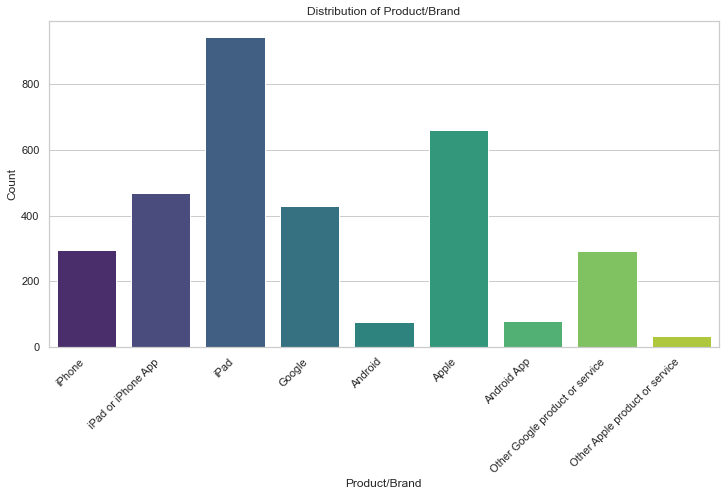

In [88]:
# Visualize these distributions
emotion_distribution = df['Product/Brand'].value_counts()

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a count plot
plt.figure(figsize=(12, 6))
sns.countplot(x='Product/Brand', data=df, palette="viridis")

# Add labels and title
plt.title('Distribution of Product/Brand')
plt.xlabel('Product/Brand')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

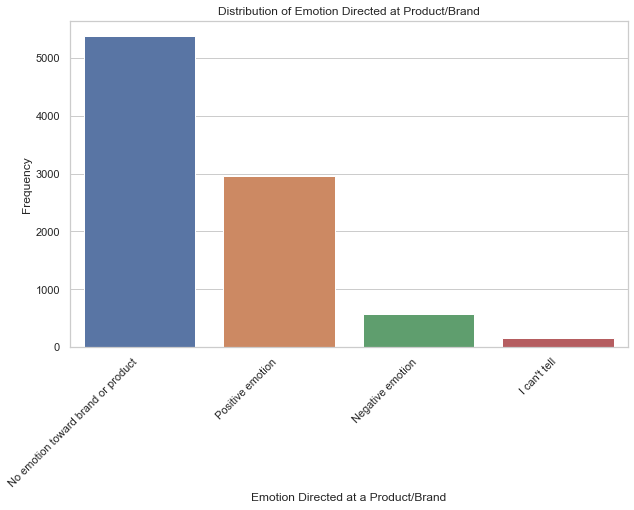

In [89]:
#Visualize distributions of emotions
emotion_distribution = df['Emotion'].value_counts()

# Bar chart for 'Emotion'
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_distribution.index, y=emotion_distribution.values, palette='deep')
plt.title('Distribution of Emotion Directed at Product/Brand')
plt.xlabel('Emotion Directed at a Product/Brand')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [133]:
# combine 'neutral' and 'I can't tell' as both being neutral sentiment
df['Emotion'] = df['Emotion'].replace({
    "I can't tell": 'Neutral emotion',
    'No emotion toward brand or product': 'Neutral emotion'
})

print (df['Emotion'].value_counts())

Neutral emotion     5528
Positive emotion    2968
Negative emotion     569
Name: Emotion, dtype: int64


In [134]:
# combine negative and neutral emotions as being non-positive
df['Emotion'] = df['Emotion'].replace({
    "Neutral emotion": 'Not Positive',
    'Negative emotion': 'Not Positive'
})

print (df['Emotion'].value_counts())

Not Positive        6097
Positive emotion    2968
Name: Emotion, dtype: int64


In [135]:
# simplify by defining different Product/Brand values as either Apple or Google

df['brand'] = df['Product/Brand'].map({
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'iPhone': 'Apple',
    'Other Apple product or service': 'Apple',
    'Google': 'Google',
    'Android App': 'Google',
    'Android': 'Google'
})

print(df['brand'].value_counts())

Apple     2402
Google     585
Name: brand, dtype: int64


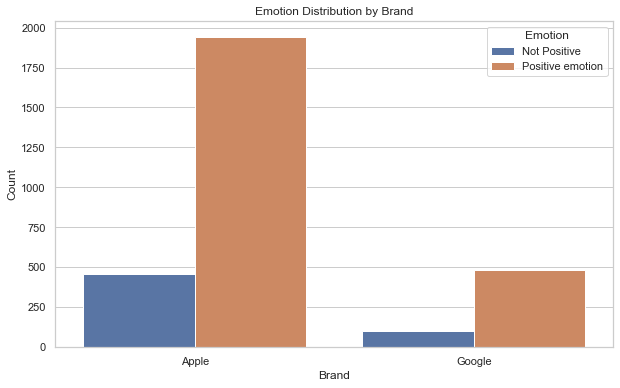

In [136]:
# plot Emotion distribution by brand
plt.figure(figsize=(10,6))
sns.countplot(x='brand', hue='Emotion', data=df)
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Emotion Distribution by Brand')
plt.show()

In [138]:
def process_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words and word.lower() in english_words]
    return tokens

In [139]:
# Separate the data into Positive and Not Positive subsets
positive_tweets = df[df['Emotion'] == 'Positive emotion']['clean_text']
not_positive_tweets = df[df['Emotion'] == 'Not Positive']['clean_text']

# Process the text for each category
positive_tokens = positive_tweets.apply(process_text)
not_positive_tokens = not_positive_tweets.apply(process_text)

# Convert token lists to sets for positive and not positive categories
unique_positive_tokens = set([token for sublist in positive_tokens for token in sublist])
unique_not_positive_tokens = set([token for sublist in not_positive_tokens for token in sublist])

# Exclude words that appear in more than one category
unique_positive_words = unique_positive_tokens - (unique_not_positive_tokens)
unique_not_positive_words = unique_not_positive_tokens - (unique_positive_tokens)

In [140]:
# Flatten the list of tokens for each category
positive_tokens_flat = [token for sublist in positive_tokens for token in sublist]
not_positive_tokens_flat = [token for sublist in not_positive_tokens for token in sublist]

## Data Preprocessing

In [142]:
df['Emotion'].value_counts()

0    6097
1    2968
Name: Emotion, dtype: int64

In [143]:
df['Product/Brand'].value_counts()

iPad                               943
Apple                              659
iPad or iPhone App                 469
Google                             428
iPhone                             296
Other Google product or service    293
Android App                         80
Android                             77
Other Apple product or service      35
Name: Product/Brand, dtype: int64

In [144]:
df['brand'].value_counts()

Apple     2402
Google     585
Name: brand, dtype: int64

In [141]:
enc = LabelEncoder()

# Fit and transform the specified column in the DataFrame
df['Emotion'] = enc.fit_transform(df['Emotion'])
df['brand'] = enc.fit_transform(df['brand'])
df['Product/Brand'] = enc.fit_transform(df['Product/Brand'])

print(df['brand'].value_counts())
print(df['Emotion'].value_counts())

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['float', 'str']

# Modeling

# Evaluation

# Conclusions

## Limitations

## Recommendations

## Next Steps